# Collect all data using Webscraping & API's

In [1]:
# markdown code
#!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
#!jupyter nbconvert --to pdf xxx.ipynb

## Dependencies

In [3]:
import requests
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import time
import warnings
from datetime import datetime
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore")

# API Keys

In [4]:
api_key_census_bureau = 'fcc8db463ea070b8f12935d522a4caadf6bc7246'
#api_key_census_bureau = '3ec46315ae4c764e72f24b8ef7f266d5745f32e3'
api_key_bls = '98124ab16a28423cbd09434c0f8cd38e'
#api_key_bls = "5a660d640ebc46f8a8485e9119cd8e6b"
#api_key_bls = "1da7a8cc0ade4a82ba1a2f8ff6bd8161"

# Bulk Download the Historical Senate Election Results

In [5]:
def webscrape_senate_results_by_year_colab(year):

    # collect the html data from the link below by inputting the desired year
    source_url = f"https://www.fec.gov/introduction-campaign-finance/election-results-and-voting-information/federal-elections-{year}"
    response = requests.get(source_url)

    # create an exception for the years without data
    if response.status_code == 200:

      # parse the contents of the html response
      soup = BeautifulSoup(response.text, 'html.parser')

      # collects all contents with the <a...</a> tag - the links will be here
      tags = soup.find_all('a', href=True)

      # create an empty list to store the collected excel files
      excel_urls = []

      # iterate over the tags to locate and save excel urls to the empty list
      for tag in tags:

          # extracts the url from the tag
          href = tag.get('href')

          # add only the urls that directly download excel files from the website
          if href.endswith(('.xlsx', '.xls')):
              url2 = 'https://www.fec.gov'
              file_url = href if href.startswith('http') else url2 + href
              excel_urls.append(file_url)

      # the first excel file is the one i want
      link = excel_urls[0]


      local_filename = (f'/raw/{year}_raw_senate_results')

      # open a download stream to the excel data
      with requests.get(link, stream=True) as r:
          r.raise_for_status()

          # save the downloaded content
          with open(local_filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  if chunk:
                      f.write(chunk)

      return print(f'{local_filename} has been successfully saved!!')

    else:
      print(f"They havn't released info for {year} yet!")

In [6]:
# create a folder to store raw data
download_directory = "/raw"
os.makedirs(download_directory, exist_ok=True)

# senate elections are held on even years so there is no data on odd years
years = [2016, 2018, 2020]

for year in years:
  webscrape_senate_results_by_year_colab(year)

/raw/2016_raw_senate_results has been successfully saved!!
/raw/2018_raw_senate_results has been successfully saved!!
/raw/2020_raw_senate_results has been successfully saved!!


# Process the Bulk Data

In [11]:
def process_senate_results(year):
  # grab the file from the raw folder
  excelfile = f'{year}_raw_senate_results'

  # save as an excel file to accomadate the many sheets
  xls = pd.ExcelFile(excelfile)

  # I found that the specific results i needed were stored in a sheet with the string 'Senate Results by State'.
  # I was able to work with the specific sheet this way - this was the same for each year.
  keyword = 'Senate Results by State'
  sheet_names = xls.sheet_names
  sheets = []
  for i, sheet_name in enumerate(sheet_names):
      if keyword in sheet_name:
        sheets.append(sheet_name)

  # save the data from the selected sheet to a pandas dataframe
  df = pd.read_excel(excelfile, sheet_name=sheets[0])

  # due to unique column names across years, custom scripts are required to import into pandas - get your act together FEC.
  if year == 2016:
      df.rename(columns={'D': 'DISTRICT'}, inplace=True)
  elif year == 2020:
      df.rename(columns={'FEC ID': 'FEC ID#', '(I) Incumbent Indicator': '(I)'}, inplace=True)
  else:
    pass

  # rename columns to ones i like more, because i can
  df = df.loc[:, ['STATE ABBREVIATION', 'DISTRICT', 'FEC ID#', '(I)', 'CANDIDATE NAME (First)', 'CANDIDATE NAME (Last)', 'PARTY', 'GENERAL VOTES ', 'GENERAL %']]
  df = df.rename(columns={
    'STATE ABBREVIATION': 'state',
    'DISTRICT': 'district',
    'FEC ID#': 'fec_id',
    '(I)': 'incumbent',
    'CANDIDATE NAME (First)': 'first_name',
    'CANDIDATE NAME (Last)': 'last_name',
    'PARTY': 'party',
    'GENERAL VOTES ': 'votes',
    'GENERAL %': 'vote_share'
    })

  # add a year column
  df['year'] = year

  # move the year column to the first position
  year_column = df.pop('year')
  df.insert(0, 'year', year_column)

  return df

In [19]:
# change current directory to raw
os.chdir('/raw')

# process each year
senate_2016 = process_senate_results(2016)
senate_2018 = process_senate_results(2018)
senate_2020 = process_senate_results(2020)

# combine into one dataframe
raw_senate_results = pd.concat([senate_2016, senate_2018, senate_2020], ignore_index=True)
raw_senate_results.to_excel('raw_senate_results.head(3).xlsx', index=False)
raw_senate_results.head(3)

,year,state,district,fec_id,incumbent,first_name,last_name,party,votes,vote_share
0,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,AL,S,S6AL00013,(I),Richard C.,Shelby,R,1335104.0,0.639588
2,2016,AL,S,S6AL00310,NaN,Jonathan,McConnell,R,NaN,NaN


# Filter the processed Data

In [13]:
def filter_senate_results(df):
  # remove candidates without FEC ID numbers
  filtered_df = df.dropna(subset=['fec_id'])

  # remove candidates with less than 1% voteshare,
  filtered_df = filtered_df[filtered_df['vote_share'] >= 0.01]

  # remove special elections
  filtered_df = filtered_df[filtered_df['district'] != 'S-UNEXPIRED TERM']
  filtered_df = filtered_df.drop('district', axis=1)

  state_year_counts = filtered_df.groupby('state')['year'].nunique()
  states_with_more_than_2_years = state_year_counts[state_year_counts > 2].index.tolist()
  filtered_df = filtered_df[(filtered_df['year'] != 2020) | (filtered_df['state'] != states_with_more_than_2_years[0])]

  # round to three decimals
  filtered_df[['votes', 'vote_share']] = filtered_df[['votes', 'vote_share']].round(3)

  # create another class for parties outside dem, rep, and other.
  def map_party(party):
      if party in ['D', 'R']:
          return party
      else:
          return 'O'
  filtered_df['party'] = filtered_df['party'].apply(map_party)

  # make incumbency a numerical binary feature
  filtered_df['incumbent'] = filtered_df['incumbent'].fillna(0)
  filtered_df.loc[filtered_df['incumbent'] != 0, 'incumbent'] = 1

  return filtered_df

In [47]:
# process the raw senate data from 2016-2020
filtered_senate_results = filter_senate_results(raw_senate_results)

# weird error where one of the fec_id's was wrong. It was the fec_id for CARR, BOB. At the end of script 3. I found that some of the candidates
# didnt have their PCC ids in the list of official ids. This turns out was because they hadnt filed. Then when i left joined the committee totals to the candidate df,
# there were another 25 or so that didnt match up, again, these were all due to the committee not raining anoy money. EXCEPT for one when i searched it, the named BOB CARR popped upo and not GARY PETERS.
filtered_senate_results['fec_id'] = filtered_senate_results['fec_id'].replace('S4MI00298', 'S4MI00355')

# create a master list of candidates for later
filtered_senate_results['fec_id'] = filtered_senate_results['fec_id'].str.replace(' ', '')
candidate_master_list = filtered_senate_results['fec_id'].to_list()

# reset the index
filtered_senate_results.reset_index(drop=True, inplace=True)

# display for the fans
filtered_senate_results.head(3)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share
0,2016,AL,S6AL00013,1,Richard C.,Shelby,R,1335104.0,0.640
1,2016,AL,S6AL00302,0,Ron,Crumpton,D,748709.0,0.359
2,2016,AK,S4AK00099,1,Lisa,Murkowski,R,138149.0,0.444


# Age

## Next I manually collected age information and uploaded via an excel file. I attempted to automate it with two different methods but came up short and landed on adding them manually. First attempt: get candidate ages from the FEC API. It turns out you cant get DOB with the FEC api. Below shows the available candidate information. Here is the link to get the API key. You just need an email. The second attempt: chat gpt api. Was terribly unreliable. https://api.open.fec.gov/developers/

In [20]:
# load in the excel file created manually
os.chdir('/content')
ages = pd.read_excel('1_candidate_ages.xlsx')
senate_results_with_ages = pd.merge(filtered_senate_results, ages[['year', 'fec_id', 'age']], on=['year', 'fec_id'], how='left')
senate_results_with_ages.shape[0]

# remove all candidates whos age didnt populate on a google search.
with_age = senate_results_with_ages.dropna(subset=['age'])
without_age = senate_results_with_ages[senate_results_with_ages['age'].isna()].drop(columns=['age'])
with_age.shape[0]

# combine for visuals
senate_results_with_ages['source'] = 'all'
with_age['source'] = 'with_age'
without_age['source'] = 'without_age'
combined_df = pd.concat([senate_results_with_ages, with_age, without_age], ignore_index=True)

## I was able to find 284/323 ages online. Missing Values introduce bias if their absence is dependent on features missing from the analysis. By comparing the data with and without age, we are able to see if the missing data is randomly missing, dependent on something in our dataset, or dependent on something unknown. Nearly all candidates in the democratic and republican parties had their age easily accessable via google search. Although most libertarians and people from smaller parties are found easily online, the people that arn't found are rarely republicans or democrats. No state lost more than 4 candidiates. All states remain well represented; the least represented states (8) have 4 repsentitive candidates and the most is Louisiana with 14 repsentitive candidates

<Figure size 500x300 with 0 Axes>

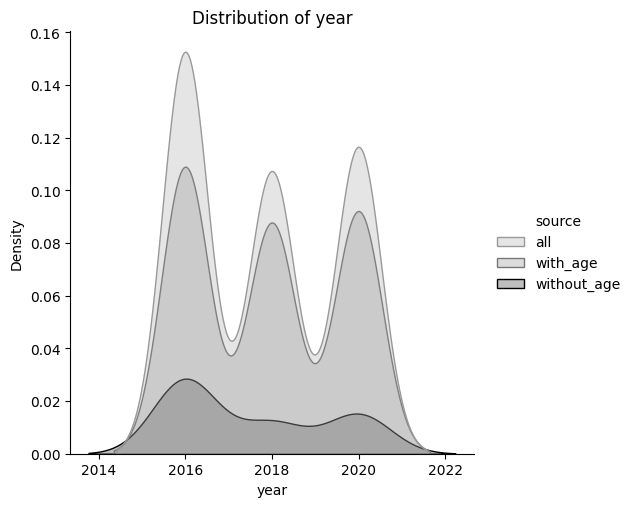

<Figure size 500x300 with 0 Axes>

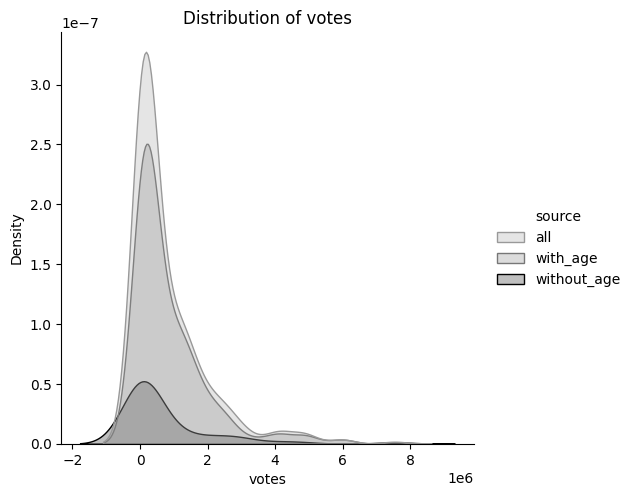

<Figure size 500x300 with 0 Axes>

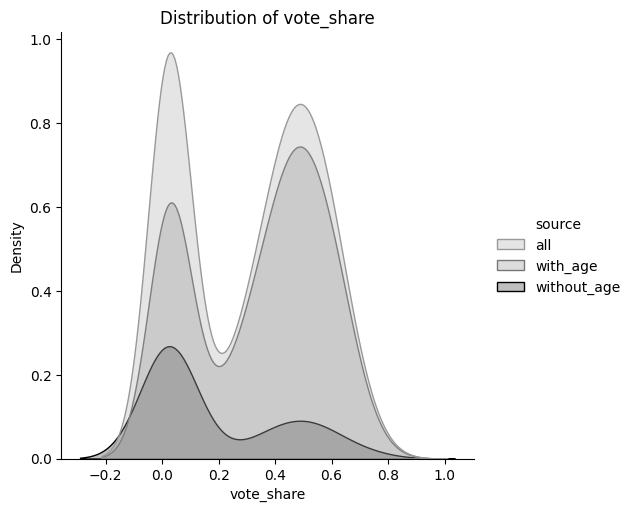

In [21]:
# plot numerical distrobutions of year total votes, and vote share
columns_to_compare = ['year', 'votes', 'vote_share']
for column in columns_to_compare:
    if column in combined_df.columns:
        plt.figure(figsize=(5, 3))
        custom_palette = sns.color_palette(["#999999","#777777","#000000"])
        sns.displot(data=combined_df, x=column, hue='source', kind='kde', fill=True, palette=custom_palette)
        plt.title(f'Distribution of {column}')
        plt.show()

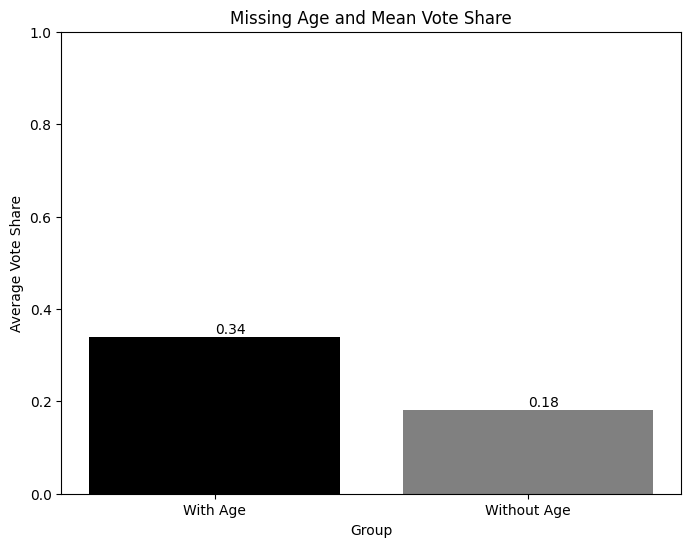

In [22]:
# compare average vote_share across age and no age
average_both_ages = with_age['vote_share'].mean()
average_without_age = without_age['vote_share'].mean()

# plot
data = {
    'Group': ['With Age', 'Without Age'],
    'Average Vote Share': [average_both_ages, average_without_age]
}
df = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
bars = plt.bar(df['Group'], df['Average Vote Share'], color=['black', 'grey'])
plt.title('Missing Age and Mean Vote Share')
plt.ylabel('Average Vote Share')
plt.xlabel('Group')
plt.ylim(0, 1)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')
plt.show()

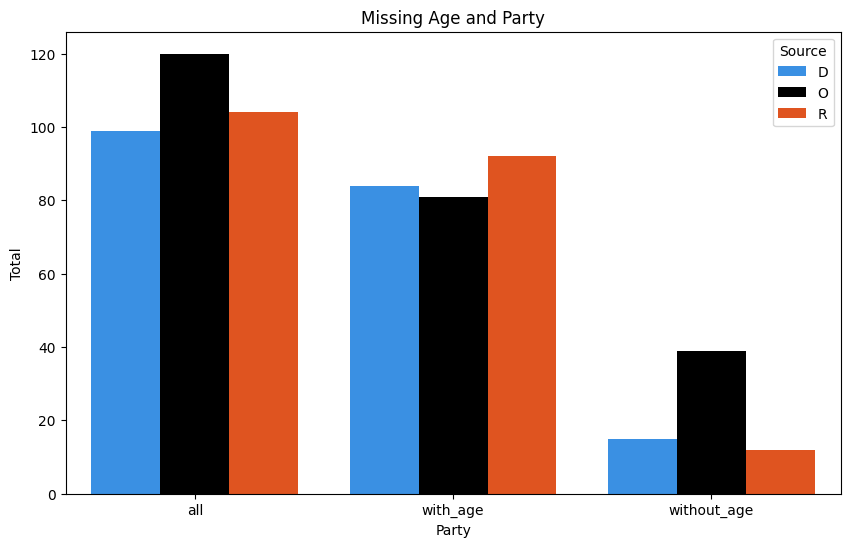

In [23]:
# group by party
count_grouped = combined_df.groupby(['source', 'party']).size().reset_index(name='count')

# plot
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette(["#1E90FF","#000000","#FF4500"])
sns.barplot(x='source', y='count', hue='party', data=count_grouped, palette=custom_palette)
plt.xlabel('Party')
plt.ylabel('Total')
plt.title('Missing Age and Party')
plt.legend(title='Source')
plt.show()

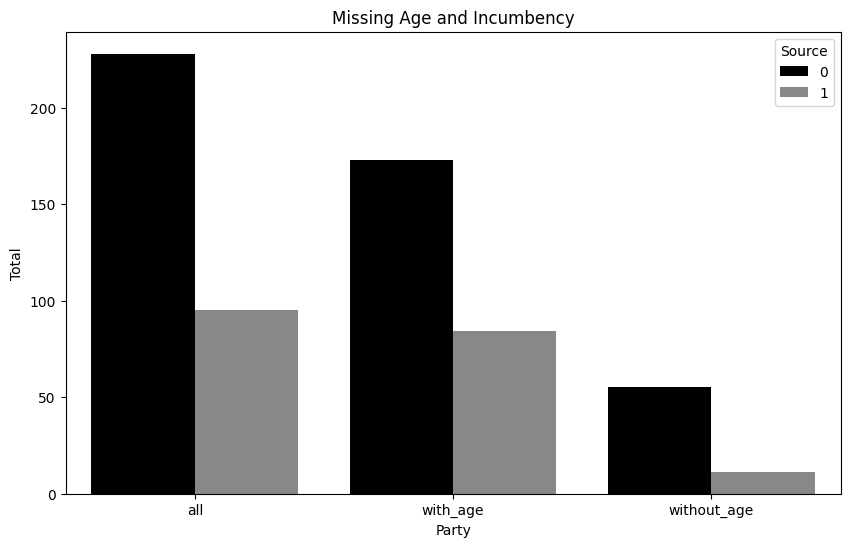

In [24]:
# group by incumbent
count_grouped1 = combined_df.groupby(['source', 'incumbent']).size().reset_index(name='count')

# plot
plt.figure(figsize=(10, 6))
custom_palette = sns.color_palette(["#000000","#888888","#FF4500"])
sns.barplot(x='source', y='count', hue='incumbent', data=count_grouped1, palette=custom_palette)
plt.xlabel('Party')
plt.ylabel('Total')
plt.title('Missing Age and Incumbency')
plt.legend(title='Source')
plt.show()

In [25]:
# group by states
count_grouped2 = combined_df.groupby(['source', 'state']).size().reset_index(name='count')

## Should i remove candidates without age information?
### Most of the candidates removed were from outside of the two major parties and had a small vote share - ten times lower on average. Running as a Democrat or Republican is advantagous so this isnt unusual. Additionally, a disporoportionate amount of candidates with low total votes (from smaller states) - not just low vote share. The total distobutions of the year and party features do not change much after removal of the candidates. This may make the model biased towards large states, big parties, and incumbent candidates. This added bias is acceptbale because i want to learn how to predict close races, ones where I know who the finalists are but need to see who has that intangible edge. This model is biased towards candidates who have over 3% vote-share, but i am mostly concerned about these candidates anyways.

In [27]:
# this is me deciding to removve the candiates without easily accessible ages via google searches.
senate_results = with_age

# Total Population and Education Ratio by State

In [28]:
# load in an excel file that adds the state codes required for the API
state_mapping = pd.read_excel('1_state_mapping.xlsx', dtype=str)
senate_results = senate_results.merge(state_mapping, how='left', on='state')
senate_results.head(3)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,age,source,full_state,state_code
0,2016,AL,S6AL00013,1,Richard C.,Shelby,R,1335104.0,0.640,81.0,with_age,Alabama,01
1,2016,AL,S6AL00302,0,Ron,Crumpton,D,748709.0,0.359,48.0,with_age,Alabama,01
2,2016,AK,S4AK00099,1,Lisa,Murkowski,R,138149.0,0.444,58.0,with_age,Alaska,02


In [29]:
senate_results['total_pop'] = None
senate_results['no_high_school'] = None
senate_results['bach'] = None

In [34]:
# for each row, using the state year combo add the state data into the empty rows created above
for index, row in senate_results.iterrows():

      # lets use census data from 5 years ago to ensure that the data will be easy to collect in the future
      state_code = row['state_code']
      year = row['year'] - 5

      # these codes were found online
      # grab the data one metric at a time
      combined_vars = list(zip(["B01003_001E", 'B06009_002E', 'B06009_005E'], ["total_pop", "no_high_school", "bach"]))
      for pair in combined_vars:
        code, metric = pair

        # get the html response
        url = f"https://api.census.gov/data/{year}/acs/acs1?get={code}&for=state:{state_code}&key={api_key_census_bureau}"
        response = requests.get(url)

        # add data to dataframe
        if response.status_code == 200:
            result = response.json()
            value = float(result[1][0])
            value = int(value)
            senate_results.at[index, metric] = value
        else:
          pass

# feature transformation: to be able to make comparisons across states i need mitigate population differences
senate_results['education_ratio'] = senate_results['bach'] / senate_results['no_high_school']
senate_results.head(3)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,age,source,full_state,state_code,total_pop,no_high_school,bach,unemployment,education_ratio
0,2016,AL,S6AL00013,1,Richard C.,Shelby,R,1335104.0,0.640,81.0,with_age,Alabama,01,4802740,551746,443488,6.141667,0.80379
1,2016,AL,S6AL00302,0,Ron,Crumpton,D,748709.0,0.359,48.0,with_age,Alabama,01,4802740,551746,443488,6.141667,0.80379
2,2016,AK,S4AK00099,1,Lisa,Murkowski,R,138149.0,0.444,58.0,with_age,Alaska,02,722718,37621,77153,6.3,2.050796


# Unemployment

In [35]:
senate_results['unemployment'] = None

In [36]:
# for each row, using the state year combo add the unemployment data into the empty row
for index, row in senate_results.iterrows():

  state_code = row['state_code']
  year = row['year'] - 1
  state_name = row['full_state']

  # grab the html data
  base_url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
  series_id = "LAUST"
  query = f"{series_id}{state_code}0000000000003"
  #series_id = "CUUR0000SA0" change for inflation
  #query = f"{series_id}" change for inflation
  headers = {"Content-Type": "application/json"}
  data = {
      "registrationKey": api_key_bls,
      "seriesid": [query],
      "startyear": year,
      "endyear": year
  }
  response = requests.post(base_url, headers=headers, json=data)

  # convert to json
  if response.status_code == 200:

      # grab the data
      result = response.json()
      data = result['Results']['series'][0]['data']

      # convert to a DataFrame and make numeric
      df = pd.DataFrame(data)
      df['value'] = pd.to_numeric(df['value'])

      # average the monthly values
      length = df.shape[0]
      yearly_average = df['value'].sum()/length

      # add to senate data frame
      senate_results.at[index, 'unemployment'] = yearly_average

senate_results.head(3)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,age,source,full_state,state_code,total_pop,no_high_school,bach,unemployment,education_ratio
0,2016,AL,S6AL00013,1,Richard C.,Shelby,R,1335104.0,0.640,81.0,with_age,Alabama,01,4802740,551746,443488,6.141667,0.80379
1,2016,AL,S6AL00302,0,Ron,Crumpton,D,748709.0,0.359,48.0,with_age,Alabama,01,4802740,551746,443488,6.141667,0.80379
2,2016,AK,S4AK00099,1,Lisa,Murkowski,R,138149.0,0.444,58.0,with_age,Alaska,02,722718,37621,77153,6.3,2.050796


# Money

## Create a list of Candidate ID's from my Project

In [37]:
# create a list of the candidates I care about
candidates = senate_results['fec_id'].to_list()
len(candidates)

257

## Download Bulk Committee Data

In [38]:
# create a folder to store raw data
download_directory = "/raw"
os.makedirs(download_directory, exist_ok=True)
os.chdir('/raw')

# save the raw committee data for each year
years = ['2016', '2018', '2020']
for year in years:

  last_two_digits = year[-2:]
  source_url = f'https://www.fec.gov/files/bulk-downloads/{year}/ccl{last_two_digits}.zip'
  filename = source_url.split('/')[-1]

  # send get request
  response = requests.get(source_url)
  if response.status_code == 200:

        #save data to zip file
      with open(filename, 'wb') as f:
          f.write(response.content)
      zip_file_name = f'ccl{last_two_digits}.zip'
      with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        for file_info in zip_ref.infolist():

          # extract from zip file
          download_directory = "/raw"
          zip_ref.extractall(download_directory)

          # rename
          custom_name = f"linkages_{year}.txt"
          extracted_file_path = os.path.join(download_directory, file_info.filename)
          new_file_path = os.path.join(download_directory, custom_name)
          os.rename(extracted_file_path, new_file_path)

  else:
      break

# load into pandas data frames
os.chdir('/raw')
column_names = ['fec_id', 'eh1', 'year', 'committee_id', 'eh2', 'designation', 'eh4']
df1 = pd.read_csv('linkages_2016.txt', sep='|', names=column_names)
df2 = pd.read_csv('linkages_2018.txt', sep='|', names=column_names)
df3 = pd.read_csv('linkages_2020.txt', sep='|', names=column_names)

# combine dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
combined_df.drop(['eh1', 'eh2', 'eh4'], axis=1, inplace=True)
all_committees = combined_df[combined_df['fec_id'].str.startswith('S')]
all_committees.shape[0]

3636

## Filter out the irrelevant committees

In [39]:
# collect all unique (year, fec_id) pairs in the project
final_df_pairs = senate_results[['year', 'fec_id']].drop_duplicates()
final_df_pairs['joel'] = 1

# filter so only relevant committees remain
project_committees = pd.merge(all_committees, final_df_pairs, on=['year', 'fec_id'], how='left')
project_committees = project_committees[project_committees['joel'] == 1]
project_committees.head(15)

,fec_id,year,committee_id,designation,joel
0,S0AK00121,2016,C00522730,P,1.0
11,S0AR00150,2016,C00576280,J,1.0
12,S0AR00150,2016,C00614529,J,1.0
13,S0AR00150,2016,C00476317,P,1.0
28,S0CO00211,2016,C00614438,J,1.0
29,S0CO00211,2016,C00545855,J,1.0
30,S0CO00211,2016,C00458398,P,1.0
31,S0CO00211,2016,C00585737,J,1.0
32,S0CO00211,2016,C00591263,J,1.0
33,S0CO00211,2016,C00575522,J,1.0


## Find the number of committees each candidate is associated with

In [40]:

# group by candidates and join counts to the senate dataframe
project_committees2 = project_committees.groupby(['fec_id', 'year']).size().reset_index(name='committee_count')

# combine dfs
senate_results = pd.merge(senate_results, project_committees2, on=['fec_id', 'year'], how='left')

# format as integer
senate_results['committee_count'] = senate_results['committee_count'].replace('nan', np.nan)
senate_results['committee_count'] = senate_results['committee_count'].replace([np.inf, -np.inf], np.nan).fillna(0)
senate_results['committee_count'] = senate_results['committee_count'].astype(int)

senate_results.head(3)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,age,source,full_state,state_code,total_pop,no_high_school,bach,unemployment,education_ratio,committee_count
0,2016,AL,S6AL00013,1,Richard C.,Shelby,R,1335104.0,0.640,81.0,with_age,Alabama,01,4802740,551746,443488,6.141667,0.80379,1
1,2016,AL,S6AL00302,0,Ron,Crumpton,D,748709.0,0.359,48.0,with_age,Alabama,01,4802740,551746,443488,6.141667,0.80379,1
2,2016,AK,S4AK00099,1,Lisa,Murkowski,R,138149.0,0.444,58.0,with_age,Alaska,02,722718,37621,77153,6.3,2.050796,6


## Narrow down to only the Principal Campaign Committees (Each Candidate only gets one PCC) I will only calculate the total amount received from individuals (NOT PACs) to their PCC committee. The number of comiittees figure is meant to cature to advantage of large organizational support. Begining January the year before the election, i calculate the total amount received up to 12m, 3m, and 1m before the election. The totals are slightly lower than reported on the FEC page because it doesn't include conrtibution receipts from more than 22 months before the election.

In [41]:
pcc_committees = project_committees[project_committees['designation'] == 'P']
x = pcc_committees.shape[0]
print("There are 284 total candidates but only", x, "have a Principal Campaign Committee")

There are 284 total candidates but only 220 have a Principal Campaign Committee


In [42]:
# look at which candidates do not have a Principal Campaign Committee. prints average voteshare of people without a pcc. Makes since that it is very low.
candidates_with_pcc = pcc_committees['fec_id'].to_list()
candidates = senate_results['fec_id'].to_list()
unique_candidates = list(set(candidates) - set(candidates_with_pcc))
without_pcc_df = senate_results[senate_results['fec_id'].isin(unique_candidates)]
without_pcc_df['vote_share'].mean()

0.033857142857142856

# load in the contribution data then divide into election years that are sorted into three 'look back' periods. 12m total, 3m, & 1m.

In [43]:
def combine_monthly_dfs(year, lookback):

  # create a list of the file names (each file holds all receipts for one month) needed to create total
  if lookback == 12:
    # initialize
    start_year = int(year) - 1
    start_month = 1

    # initialize
    end_year = int(year) - 1
    end_month = 10
  elif lookback == 3:
    # initialize
    start_year = int(year) - 1
    start_month = 11

    # initialize
    end_year = year
    end_month = 7
  elif lookback == 1:
    # initialize
    start_year = int(year)
    start_month = 8

    # initialize
    end_year = year
    end_month = 9
  else:
    print('WELP')

  # create an empty list
  date_list = []

  # to loop through the years and months
  current_year = start_year
  current_month = start_month

  while current_year < end_year or (current_year == end_year and current_month <= end_month):
      # update current year and month in the desired format to the list
      date_list.append(f"{current_year}_{current_month}")

      # move to the next month
      current_month += 1
      if current_month > 12:
          current_month = 1
          current_year += 1

  print(date_list)


  # create list
  monthly_dataframes = []

  # loop through months
  for date in date_list:

      # load csv into list
      filename = f'{date}.csv'
      df = pd.read_csv(filename)
      monthly_dataframes.append(df)

  # combine the months
  lookback_df = pd.concat(monthly_dataframes, ignore_index=True)

  # get the total raised by each committee over those months
  lookback_df = lookback_df.groupby('CMTE_ID').agg(Transaction_Count=('CMTE_ID', 'count'), Total_Amount=('TRANSACTION_AMT', 'sum')).reset_index()

  lookback_df['year'] = year
  lookbackstr = str(lookback)
  lookback_df.rename(columns={'CMTE_ID': 'committee_id', 'Transaction_Count': f'{lookbackstr}m_count', 'Total_Amount': f'{lookbackstr}m_amount'}, inplace=True)


  return lookback_df

## lookback - 'If i lookback X months, how much money had i raised then?'

In [45]:
lookback12 = 12
lookback3 = 3
lookback1 = 1

## 2016. Save total contrbutions received for only the relevant committees for each of the three lookback periods. There is no overlap (double computing) so i will need to add them sequentially to get totals. To calculate the 3m lookback, i start with the 12m lookback and then add the 11m-3m lookvback months.

In [48]:
download_directory = "/months"
os.makedirs(download_directory, exist_ok=True)

##I manually added the month files into the month directory

In [49]:
# change current directory to raw
os.chdir('/months')

In [50]:
#2016
# grab committee totals for eacv period. it will print the months used to calculate each df.
receipts_2016_12m = combine_monthly_dfs(2016, lookback12)
receipts_2016_3m = combine_monthly_dfs(2016, lookback3)
receipts_2016_1m = combine_monthly_dfs(2016, lookback1)

# merge the dataframes
merged_df2 = pd.merge(receipts_2016_1m, receipts_2016_3m, on=['committee_id', 'year'], how='outer')
receipts_2016 = pd.merge(merged_df2, receipts_2016_12m, on=['committee_id', 'year'], how='outer')

# 2018
# grab committee totals for eacv period. it will print the months used to calculate each df.
receipts_2018_12m = combine_monthly_dfs(2018, lookback12)
receipts_2018_3m = combine_monthly_dfs(2018, lookback3)
receipts_2018_1m = combine_monthly_dfs(2018, lookback1)

# merge the dataframes
merged_df2 = pd.merge(receipts_2018_1m, receipts_2018_3m, on=['committee_id', 'year'], how='outer')
receipts_2018 = pd.merge(merged_df2, receipts_2018_12m, on=['committee_id', 'year'], how='outer')

# 2020
# grab committee totals for each period. it will print the months used to calculate each df.
receipts_2020_12m = combine_monthly_dfs(2020, lookback12)
receipts_2020_3m = combine_monthly_dfs(2020, lookback3)
receipts_2020_1m = combine_monthly_dfs(2020, lookback1)


# merge the dataframes
merged_df2 = pd.merge(receipts_2020_1m, receipts_2020_3m, on=['committee_id', 'year'], how='outer')
receipts_2020 = pd.merge(merged_df2, receipts_2020_12m, on=['committee_id', 'year'], how='outer')

['2015_1', '2015_2', '2015_3', '2015_4', '2015_5', '2015_6', '2015_7', '2015_8', '2015_9', '2015_10']
['2015_11', '2015_12', '2016_1', '2016_2', '2016_3', '2016_4', '2016_5', '2016_6', '2016_7']
['2016_8', '2016_9']
['2017_1', '2017_2', '2017_3', '2017_4', '2017_5', '2017_6', '2017_7', '2017_8', '2017_9', '2017_10']
['2017_11', '2017_12', '2018_1', '2018_2', '2018_3', '2018_4', '2018_5', '2018_6', '2018_7']
['2018_8', '2018_9']
['2019_1', '2019_2', '2019_3', '2019_4', '2019_5', '2019_6', '2019_7', '2019_8', '2019_9', '2019_10']
['2019_11', '2019_12', '2020_1', '2020_2', '2020_3', '2020_4', '2020_5', '2020_6', '2020_7']
['2020_8', '2020_9']


# Put it all together

In [51]:
all_receipts = pd.concat([receipts_2016, receipts_2018, receipts_2020], ignore_index=True)

# replace NA's with 0's
columns_to_convert = ['1m_count', '1m_amount', '3m_count', '3m_amount', '12m_count', '12m_amount']
all_receipts[columns_to_convert] = all_receipts[columns_to_convert].fillna(0)
all_receipts[columns_to_convert] = all_receipts[columns_to_convert].astype(int)

pcc_committees= pd.merge(pcc_committees, all_receipts, on=['year', 'committee_id'], how='left')

# create lookback totals
pcc_committees['3m_total'] = pcc_committees['12m_amount'] + pcc_committees['3m_amount']
pcc_committees['1m_total'] = pcc_committees['12m_amount'] + pcc_committees['3m_amount'] + pcc_committees['1m_amount']

# add to senate results
senate_results = pd.merge(senate_results, pcc_committees, on=['year', 'fec_id'], how='left')
duplicate_combos = senate_results[senate_results.duplicated(subset=['fec_id', 'year'], keep=False)]
duplicate_combos_sorted = duplicate_combos.sort_values(by=['fec_id', 'year', 'vote_share'])
duplicate_combos_sorted.head(3)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,age,...,designation,joel,1m_count,1m_amount,3m_count,3m_amount,12m_count,12m_amount,3m_total,1m_total
13,2016,CT,S0CT00177,1,Richard,Blumenthal,O,87948.0,0.055,70.0,...,P,1.0,939.0,703381.0,2613.0,2081537.0,2925.0,2640953.0,4722490.0,5425871.0
12,2016,CT,S0CT00177,1,Richard,Blumenthal,D,920766.0,0.577,70.0,...,P,1.0,939.0,703381.0,2613.0,2081537.0,2925.0,2640953.0,4722490.0,5425871.0
142,2018,NY,S0NY00410,1,Kirsten E.,Gillibrand,O,99325.0,0.016,51.0,...,P,1.0,3801.0,358937.0,14619.0,3340088.0,16709.0,9573659.0,12913747.0,13272684.0


# Clean it up a bit

In [52]:
# locate duplicate rows
rows_to_remove1 = duplicate_combos_sorted.drop_duplicates(subset=['fec_id', 'year'], keep='last')
rows_to_remove = duplicate_combos_sorted.drop(rows_to_remove1.index)

# remove these rows
senate_results_cleaned = senate_results.drop(rows_to_remove.index)
senate_results_cleaned = senate_results_cleaned.reset_index(drop=True)

# divide by population
senate_results_cleaned['1m_total_pop'] = senate_results_cleaned['1m_total']/senate_results_cleaned['total_pop']
senate_results_cleaned['3m_total_pop'] = senate_results_cleaned['3m_total']/senate_results_cleaned['total_pop']
senate_results_cleaned['12m_total_pop'] = senate_results_cleaned['12m_amount']/senate_results_cleaned['total_pop']

## narrow to only pcc candidates with pcc committees
senate_results_cleaned = senate_results_cleaned[senate_results_cleaned['designation'] == 'P']

# replace NA's with 0's
columns_to_convert = ['1m_total_pop', '3m_total_pop', '12m_total_pop']
senate_results_cleaned[columns_to_convert] = senate_results_cleaned[columns_to_convert].fillna(0)
senate_results_cleaned.head(20)

,year,state,fec_id,incumbent,first_name,last_name,party,votes,vote_share,age,...,1m_amount,3m_count,3m_amount,12m_count,12m_amount,3m_total,1m_total,1m_total_pop,3m_total_pop,12m_total_pop
0,2016,AL,S6AL00013,1,Richard C.,Shelby,R,1335104.0,0.640,81.0,...,2500.0,357.0,421312.0,884.0,1208436.0,1629748.0,1632248.0,0.339858,0.339337,0.251614
1,2016,AL,S6AL00302,0,Ron,Crumpton,D,748709.0,0.359,48.0,...,2000.0,17.0,6130.0,1.0,250.0,6380.0,8380.0,0.001745,0.001328,0.000052
2,2016,AK,S4AK00099,1,Lisa,Murkowski,R,138149.0,0.444,58.0,...,153235.0,1019.0,1099301.0,1405.0,1560491.0,2659792.0,2813027.0,3.892289,3.680263,2.159198
3,2016,AK,S0AK00121,0,Joe,Miller,O,90825.0,0.292,48.0,...,606945.0,0.0,0.0,0.0,0.0,0.0,606945.0,0.839809,0.000000,0.000000
4,2016,AK,S8AK00082,0,Ray,Metcalfe,D,36200.0,0.116,65.0,...,18487.0,4.0,600.0,0.0,0.0,600.0,19087.0,0.026410,0.000830,0.000000
5,2016,AK,S6AK00151,0,Margaret,Stock,O,41194.0,0.132,55.0,...,111827.0,543.0,374999.0,0.0,0.0,374999.0,486826.0,0.673604,0.518873,0.000000
6,2016,AZ,S6AZ00340,0,Gary,Swing,O,138634.0,0.055,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
7,2016,AR,S0AR00150,1,John,Boozman,R,661984.0,0.598,65.0,...,261986.0,1403.0,907075.0,1161.0,895673.0,1802748.0,2064734.0,0.702774,0.613601,0.304860
8,2016,AR,S6AR00132,0,Conner,Eldridge,D,400602.0,0.362,38.0,...,159944.0,732.0,472056.0,250.0,416805.0,888861.0,1048805.0,0.356982,0.302542,0.141868
9,2016,CO,S0CO00211,1,Michael,Bennet,D,1370710.0,0.500,51.0,...,1037203.0,16067.0,5675598.0,5225.0,4179700.0,9855298.0,10892501.0,2.128774,1.926068,0.816859


# save to excel

In [53]:
# save to excel
senate_results = senate_results_cleaned
# save to excel
senate_results.to_excel('senate_results.xlsx', index=False)